<a href="https://colab.research.google.com/github/rukshar69/News_Classification/blob/main/News_Classification_MultinomialNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

In this notebook, we are going to classify news articles into categories( tech, entertainment, and sports) using Machine Learning. For the task of news classification, the dataset(collected from BBC News) contains news articles including their headlines and categories. The categories covered in this dataset are:
* Sports
* Business
* Politics
* Tech
* Entertainment


#Library Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from wordcloud import WordCloud, STOPWORDS 
sns.set_theme() ##set seaborn's default theme, also seaborn produces better looking graphs

#Data Loading

In [2]:
news_df = pd.read_csv("https://raw.githubusercontent.com/amankharwal/Website-data/master/bbc-news-data.csv", sep='\t')
news_df.head(5)

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [3]:
print(news_df.shape)
print(news_df.columns)

(2225, 4)
Index(['category', 'filename', 'title', 'content'], dtype='object')


*Category* is the dependent variable and *title* & *content* are independent variables for this dataset. There are over 2200 datapoints.

#Missing Value Analysis

For any dataset, it's very important to check whether there is any missing value in any of the dependent variable columns. If there are missing values, we have to impute data to fill those empty spaces.

In [4]:
missing_val_df = pd.DataFrame(news_df.isnull().sum())
missing_val_df.columns = ['No. of Missing Vals.']
missing_val_df

,No. of Missing Vals.
category,0
filename,0
title,0
content,0


Luckily, this dataset does not contain missing values. In real life, however, there are missing data points.

#Category Analysis

Let's count the occurrence of each type of news article

In [5]:
category_df = pd.DataFrame(news_df["category"].value_counts())
category_df.columns = ['Frequency']
category_df['Percentage_Frequency'] =(category_df['Frequency']  /category_df['Frequency'].sum())*100
category_df

,Frequency,Percentage_Frequency
sport,511,22.966292
business,510,22.921348
politics,417,18.741573
tech,401,18.022472
entertainment,386,17.348315


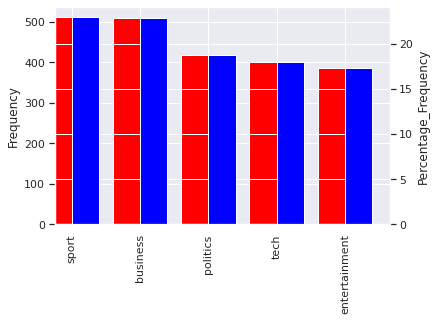

In [6]:

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

category_df.Frequency.plot(kind='bar', color='red', ax=ax, width=width, position=1)
category_df.Percentage_Frequency.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Frequency')
ax2.set_ylabel('Percentage_Frequency')

plt.show()

It seems we have imbalanced class distribution where the frequency of classes is inequal. In the given dataset, *Sports* and *Business* news are the most numerous. In contrast, *Entertainment* news have the lowest occurrence.

#Feature Extraction From Text: CountVectorizer

For extracting features from our text data, we use *sklearn*'s CountVectorizer. 
It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. This is helpful when we have multiple such texts, and we wish to convert each word in each text into vectors (for using in further text analysis). <br>
**CountVectorizer** creates a matrix in which each unique word is represented by a column of the matrix, and each text sample from the document is a row in the matrix. The value of each cell is nothing but the count of the word in that particular text sample. <br>
Inside CountVectorizer, these words are not stored as strings. Rather, they are given a particular index value. <br>
This way of representation is known as a Sparse Matrix.
For a more detailed example, read this article: [CountVectorizer Example](https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/)

For the moment, we will use *title* column's texts as training data. So, we use CountVectorizer on this column's texts to get the sparse matrix representation. And this will be used in the ML algo.

In [7]:
x = np.array(news_df['title'])
cv = CountVectorizer()

# Encode the title data
X = cv.fit_transform(x)
# Printing the identified Unique words along with their indices
vocab = cv.vocabulary_
print("Vocabulary: ", dict(itertools.islice(vocab.items(), 5)))
print("Unique Words: ", len(vocab))

# Summarizing the Encoded Texts
print("Encoded Document is:")
print(X.toarray().shape)

Vocabulary:  {'ad': 116, 'sales': 2893, 'boost': 453, 'time': 3400, 'warner': 3620}
Unique Words:  3754
Encoded Document is:
(2225, 3754)


So, our sparse matrix representation(when using only the 'title' column) has the shape (2225, 3754) since there are 2225 datapoints and 3754 unique words in the vocabulary.

#Prepare Train Test Data

let’s prepare the data for the task of training a news classification model:

In [8]:
def create_train_test_data(X,y, split = 0.33):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
  print('Split: ',split)
  print("X_Train: ", X_train.shape)
  print("Y_Train: ", y_train.shape)
  print("X_Test: ", X_test.shape)
  print("y_Test: ", y_test.shape)
  return X_train, X_test, y_train, y_test

In [9]:

y = np.array(news_df["category"])
X_train, X_test, y_train, y_test = create_train_test_data(X,y)


Split:  0.33
X_Train:  (1490, 3754)
Y_Train:  (1490,)
X_Test:  (735, 3754)
y_Test:  (735,)


#Training The Model

 Multinomial Naive Bayes algorithm is used to train our news classification model.

The Multinomial Naive Bayes is one of the variants of the Naive Bayes algorithm in machine learning. It is very useful to use on a dataset that is distributed multinomially( more on multinomial distribution from [here](https://stattrek.com/probability-distributions/multinomial.aspx)). This algorithm is especially preferred in classification tasks based on natural language processing.<br>
When there are multiple classes to classify, this algorithm can be used because to predict the label of the text. It calculates the probability of each label for the input text and then generates the label with the highest probability as output.<br>
Advantages of using this algorithm for multinomial classification are:
- Easy to use on continuous and discrete data
- Can handle large data sets
- Can classify data with multiple labels
- Good to use for training natural language processing models<br>


Do note that it's not suitable for regression. Naive Bayes algorithm is only used for textual data classification and cannot be used to predict numeric values.<br>
Multinomial Naive Bayes is also used in Spam filtering in email, Diagnosis of diseases, making decisions about treatment, Classification of RNA sequences in taxonomic studies, etc.<br>
Article on Multinomial Naive Bayes algo.:
- []()

In [10]:
multinomialnb_model = MultinomialNB()
multinomialnb_model.fit(X_train,y_train)

MultinomialNB()

#Prediction on Test Data

At first, let's use an example to see the prediction performance of this model.

In [11]:
test_string = 'Latest Apple iPhone SE 3 concept renders show a compact smartphone in the style of the iPhone 4' #a Tech news title by the looks of it

First, we have to transform it using our fitted transformer and create the sparse matrix representation since the model was trained on such matrix.

In [12]:
test_matrix = cv.transform([test_string]).toarray()
print(test_matrix.shape)
test_output = multinomialnb_model.predict(test_matrix)
print(test_output)

(1, 3754)
['tech']


Let's use our test data to make predictions and measure the accuracy.

In [13]:
test_data_predictions = multinomialnb_model.predict(X_test)
correct_prediction = np.sum(test_data_predictions == y_test)
accuracy = (correct_prediction/ len(test_data_predictions)) * 100
print(accuracy)

81.9047619047619


#90% of Training Data Results

By taking 33 percent of datapoints as test data we arrive at an approx. 82 percent accuracy. <br>
Let's use 90% of the data as training data and observe the results

In [14]:
X_train, X_test, y_train, y_test = create_train_test_data(X,y, split = 0.1)
multinomialnb_model_2 = MultinomialNB()
multinomialnb_model_2.fit(X_train,y_train)

Split:  0.1
X_Train:  (2002, 3754)
Y_Train:  (2002,)
X_Test:  (223, 3754)
y_Test:  (223,)


MultinomialNB()

In [15]:
test_data_predictions = multinomialnb_model_2.predict(X_test)
correct_prediction = np.sum(test_data_predictions == y_test)
accuracy = (correct_prediction/ len(test_data_predictions)) * 100
print(accuracy)

82.51121076233184


By taking 90% of data as training data, the model's performance has improved.

#Expanding Features

Let's now concatenate the title and the news content columns to create a new column of feature.

In [16]:
news_df['title_and_content'] = news_df['title'] + news_df['content']
news_df.head(3)

,category,filename,title,content,title_and_content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,Ad sales boost Time Warner profit Quarterly pr...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,Dollar gains on Greenspan speech The dollar ha...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,Yukos unit buyer faces loan claim The owners o...


Nows, we implement count vectorizer to convert the textual features into numerical matrix format for training. 

In [17]:
x = np.array(news_df['title_and_content'])
cv = CountVectorizer()

# Encode the title data
X = cv.fit_transform(x)
# Printing the identified Unique words along with their indices
vocab = cv.vocabulary_
print("Vocabulary: ", dict(itertools.islice(vocab.items(), 5)))
print("Unique Words: ", len(vocab))

# Summarizing the Encoded Texts
print("Encoded Document is:")
print(X.toarray().shape)

Vocabulary:  {'ad': 1750, 'sales': 23062, 'boost': 4349, 'time': 26665, 'warner': 28502}
Unique Words:  29421
Encoded Document is:
(2225, 29421)


Using the count vectorizer, we will now use about 30k features for training. Before we used about 4k features.

#Word Cloud Generation

We will generate word clouds for various categories of news to see which words are dominant in each category.

In [18]:
# Python program to generate WordCloud
def generate_wordcloud(news_content_df):
  df = news_content_df.copy()
 
  comment_words = ''
  stopwords = set(STOPWORDS)
  
  # iterate through the csv file
  for val in df.title_and_content:
      
      # typecaste each val to string
      val = str(val)
  
      # split the value
      tokens = val.split()
      
      # Converts each token into lowercase
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()
      
      comment_words += " ".join(tokens)+" "
  
  wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)
  
  # plot the WordCloud image                      
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.show()

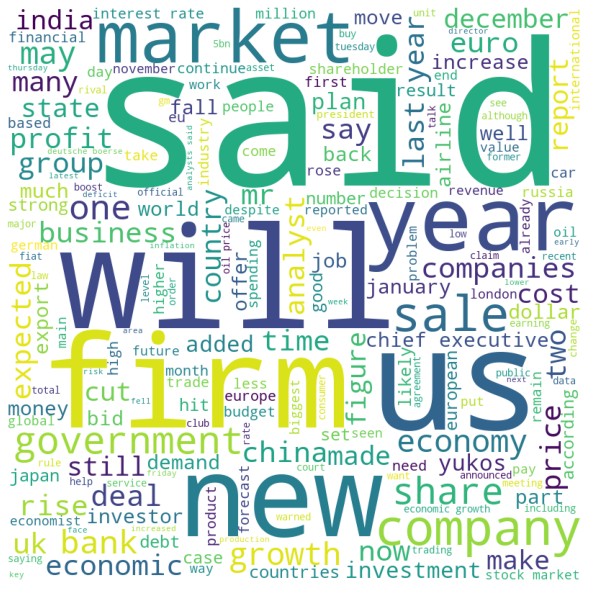

In [19]:
generate_wordcloud(news_df[news_df['category']== 'business']) #Generate word cloud for business news

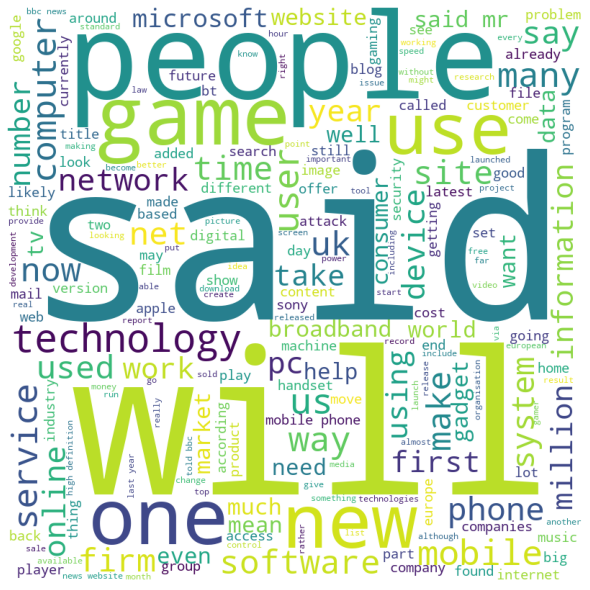

In [20]:
generate_wordcloud(news_df[news_df['category']== 'tech']) #Generate word cloud for tech news

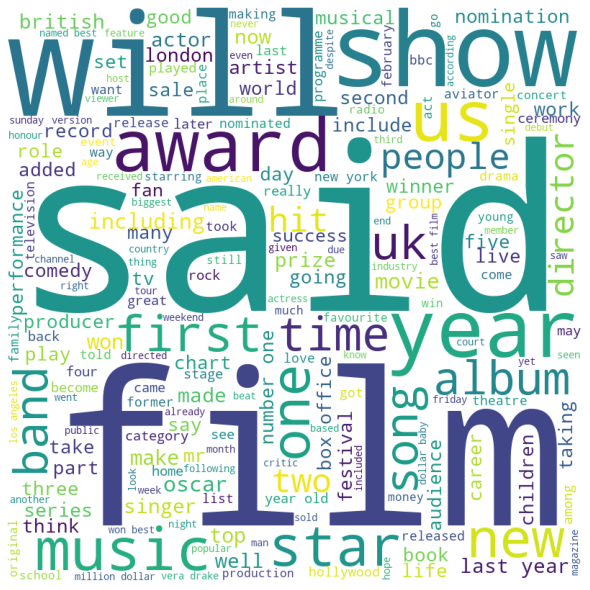

In [21]:
generate_wordcloud(news_df[news_df['category']== 'entertainment']) #Generate word cloud for entertainment news

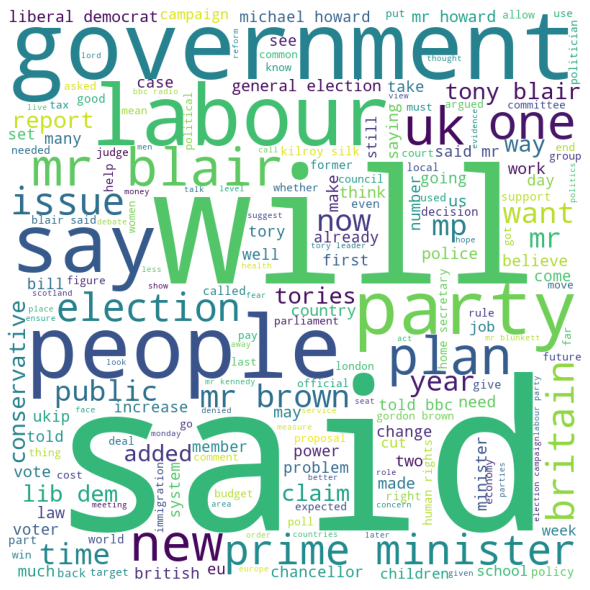

In [22]:
generate_wordcloud(news_df[news_df['category']== 'politics']) #Generate word cloud for politics news

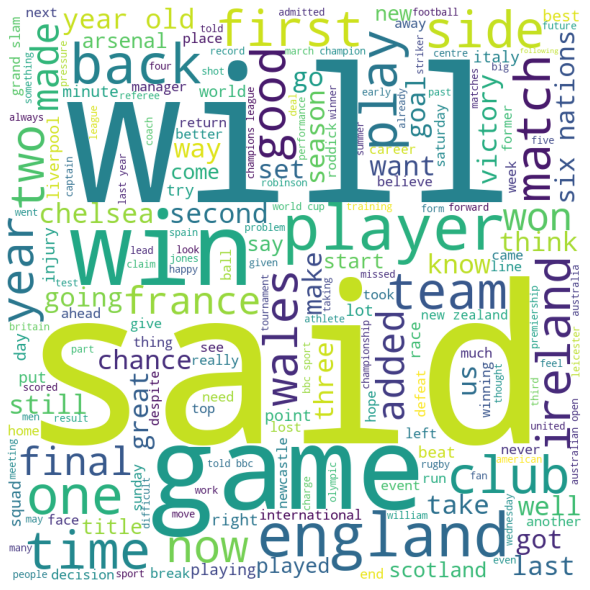

In [23]:
generate_wordcloud(news_df[news_df['category']== 'sport']) #Generate word cloud for sport news

#Training with Expanded Features

We create train and test data using 10% data as test data.

In [24]:
X_train, X_test, y_train, y_test = create_train_test_data(X,y, split = 0.1)
multinomialnb_model_expanded = MultinomialNB()
multinomialnb_model_expanded.fit(X_train,y_train)

Split:  0.1
X_Train:  (2002, 29421)
Y_Train:  (2002,)
X_Test:  (223, 29421)
y_Test:  (223,)


MultinomialNB()

In [25]:
test_data_predictions = multinomialnb_model_expanded.predict(X_test)
correct_prediction = np.sum(test_data_predictions == y_test)
accuracy_expanded = (correct_prediction/ len(test_data_predictions)) * 100
print(accuracy_expanded)

97.75784753363229


Create bar graph of accuracy from before and after

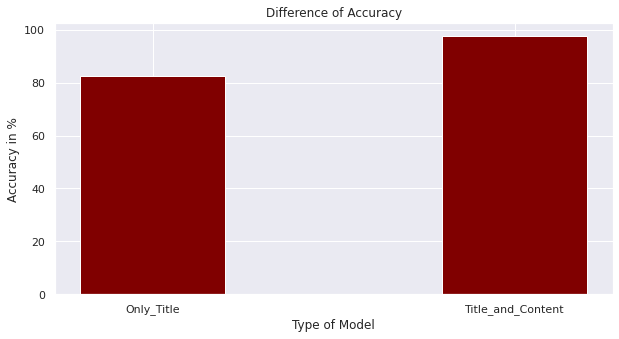

In [29]:
# creating the dataset for accuracy comparison
data = {'Only_Title':accuracy, 'Title_and_Content':accuracy_expanded,}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)

plt.xlabel("Type of Model")
plt.ylabel("Accuracy in %")
plt.title("Difference of Accuracy")
plt.show()

Expanding the features to include both the title and the news content has considerably increased the accuracy from about 82% to about 97%

#Conclusion

This notebook is for the purposes of research, experiment, reproduction of existing results, and education. 

Reference: 
- https://thecleverprogrammer.com/2021/10/07/news-classification-with-machine-learning/